鲍鱼是一种贝类，在世界许多地方被认为是美味佳肴。是铁和泛酸的极好来源，也是澳大利亚、美洲和东亚的营养食品资源和农业。100克鲍鱼就能给人体提供超过 20% 上述每日摄入营养素。鲍鱼的经济价值与年龄正相关。因此，准确检测鲍鱼的年龄对养殖户和消费者确定鲍鱼的价格具有重要意义。

然而，目前确定鲍鱼年龄的技术是相当昂贵和低效的。农场主通常把鲍鱼的壳割下来，用显微镜数鲍鱼环的数量，以估计鲍鱼的年龄。因此判断鲍鱼的年龄很困难，主要是因为鲍鱼的大小不仅取决于年龄，而且还取决于食物的供应情况。此外，鲍鱼有时会形成所谓的“发育不良”群体，这些群体的生长特性与其他鲍鱼种群有很大不同。这种复杂的方法增加了成本，限制了应用范围。本案例的目标是使用机器学习中的回归模型，找出最佳的指标来预测鲍鱼环数，进而预测鲍鱼的年龄。

## 1 数据集探索性分析

我们首先将鲍鱼数据集 `abalone_dataset.csv` 读取为 `Pandas` 的 `DataFrame` 格式。

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv("./input/abalone_dataset.csv")
data.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


查看数据集中样本数量和特征数量。

In [2]:
data.shape

(4177, 9)

|列名|类型|单位|备注|
|:----:|:----:|:----:|:----:|
|sex |	离散|	-	|M, F, and I (Infant)|
|length	|连续	|毫米	|壳体最长长度|
|diameter	|连续	|毫米	|直径|
|height	|连续	|毫米| 高度|
|whole_weight	|连续	|克|	总重量|
|shucked_weight	|连续	|克|	肉重量|
|viscera_weight	|连续	|克|	内脏重量|
|shell_weight	|连续	|克|	壳体重量|
|rings	|连续|	-	|环数量，+1.5 就是鲍鱼年龄|

数据集一共有 4177 个样本，每个样本有 9 个特征。其中 `rings` 为鲍鱼环数，能够代表鲍鱼年龄，是预测变量。除了 `sex` 为离散特征，其余都为连续变量。

首先借助 `seaborn` 中的 `countplot` 函数绘制条形图，观察 `sex` 列的取值分布情况。

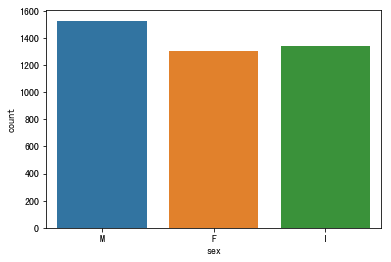

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x = "sex", data = data)

对于连续特征，可以使用 `seaborn` 的 `distplot` 函数绘制直方图观察特征取值情况。我们将 8 个连续特征的直方图绘制在一个 4 行 2 列的子图布局中。

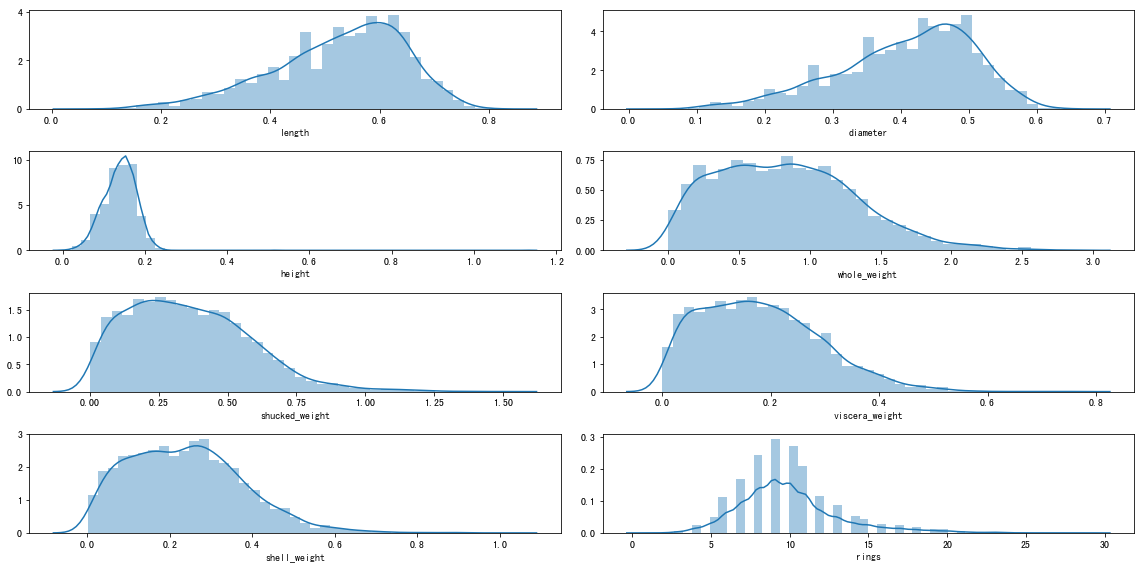

In [4]:
i = 1 # 子图记数
plt.figure(figsize=(16, 8))
for col in data.columns[1:]:
    plt.subplot(4,2,i)
    i = i + 1
    sns.distplot(data[col])  
plt.tight_layout()

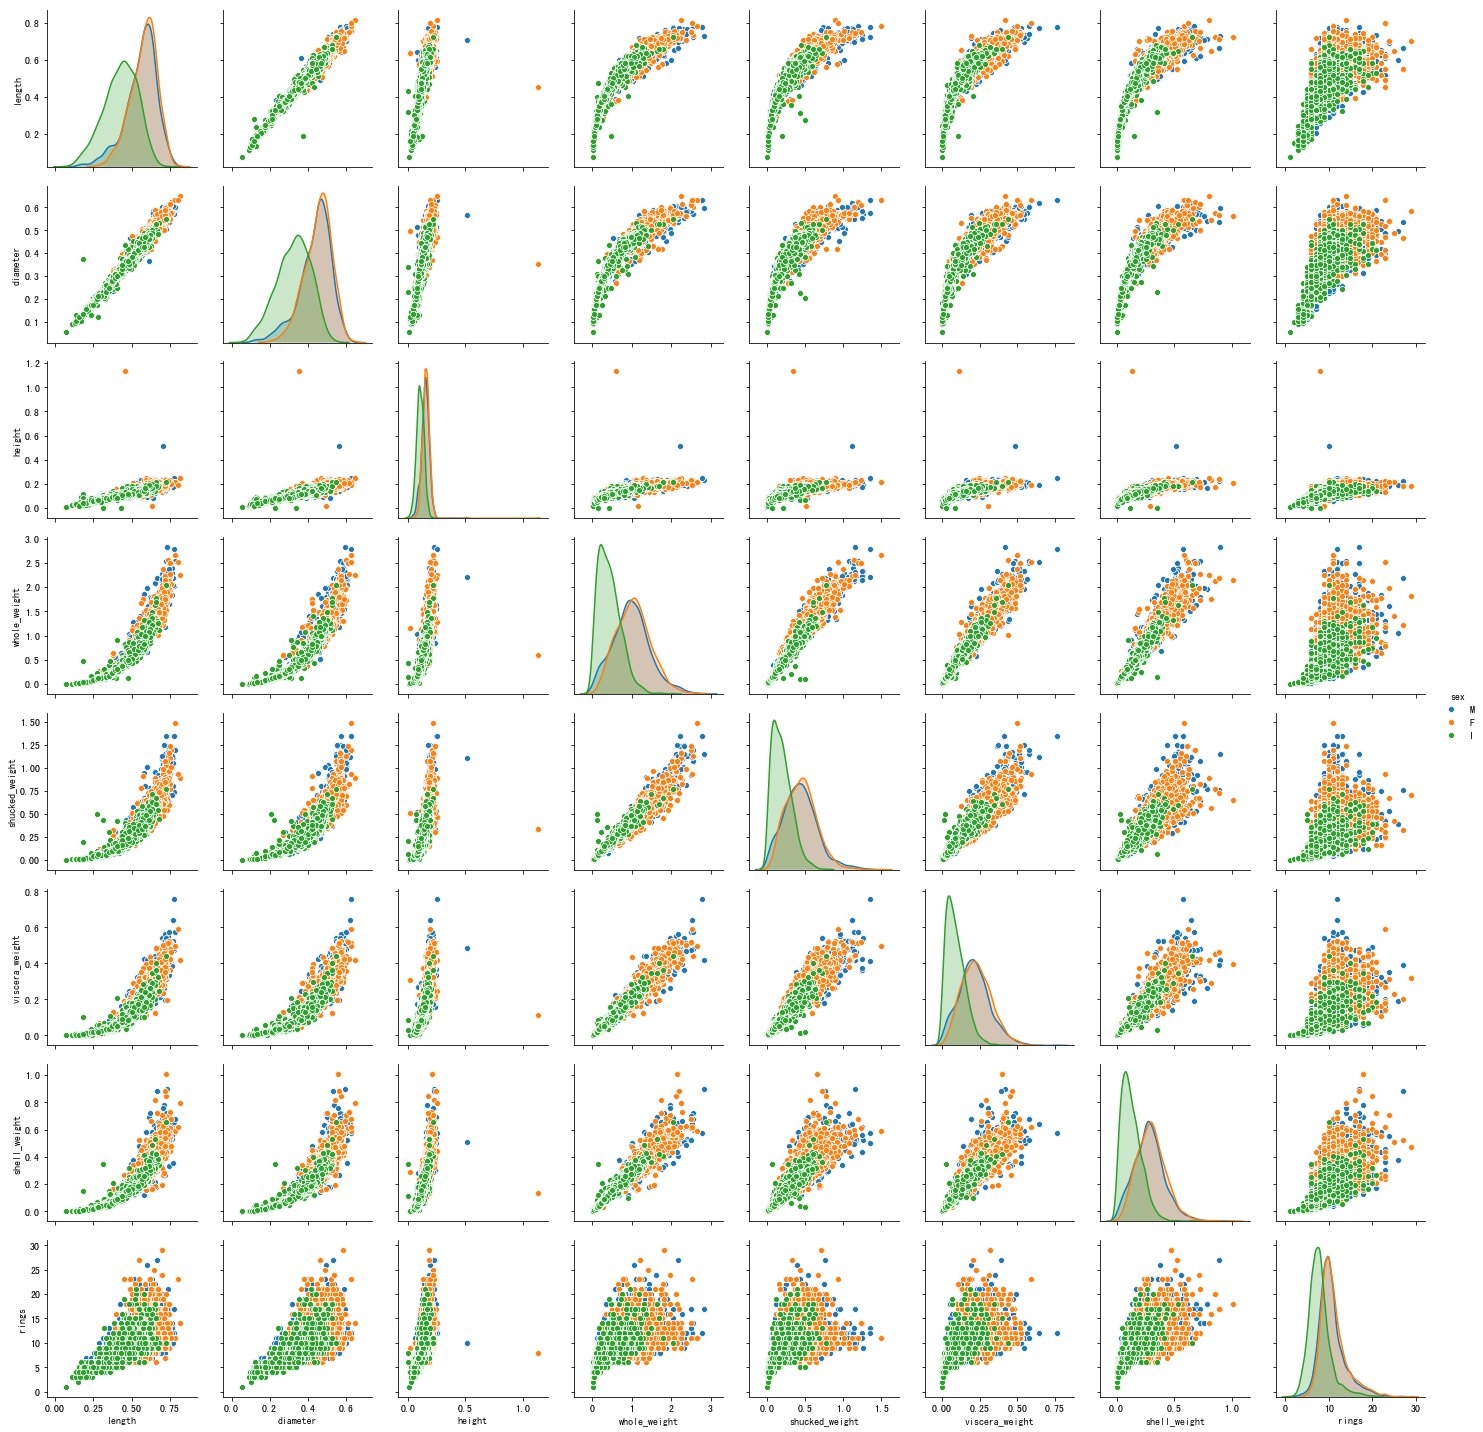

In [5]:
sns.pairplot(data,hue="sex")

从以上连续特征之间的散点图我们可以看到一些基本的结果：
+ 例如从第一行可以看到鲍鱼的长度 `length` 和鲍鱼直径 `diameter` 、鲍鱼高度 `height` 存在明显的线性关系。鲍鱼长度与鲍鱼的四种重量之间存在明显的非线性关系。

+ 观察最后一行，鲍鱼环数 `rings` 与各个特征均存在正相关性，其中与 `height` 的线性关系最为直观。 

+ 观察对角线上的直方图，可以看到幼鲍鱼（`sex` 取值为“I”）在各个特征上的取值明显小于其他成年鲍鱼。而雄性鲍鱼（`sex` 取值为“M”）和雌性鲍鱼（`sex` 取值为“F”）各个特征取值分布没有明显的差异。

为了定量地分析特征之间的线性相关性，我们计算特征之间的相关系数矩阵，并借助热力图将相关性可视化。

In [6]:
corr_df = data.corr()
corr_df

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


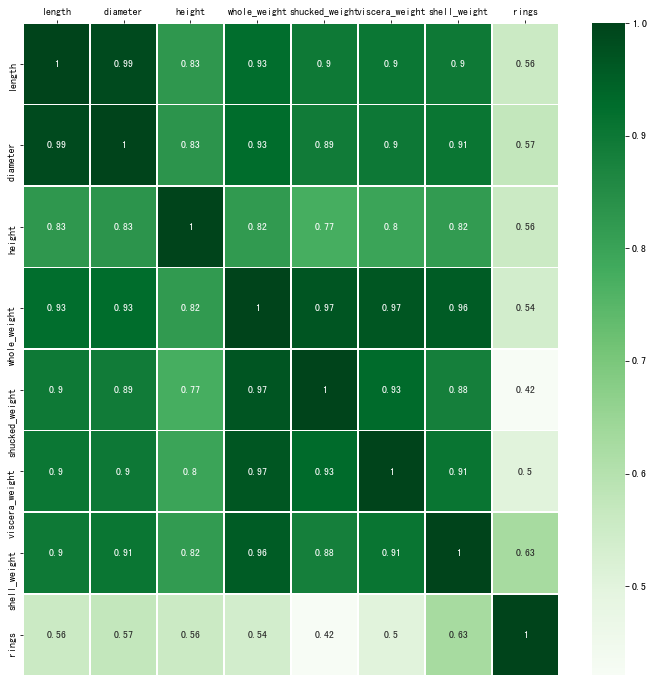

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
## 绘制热力图
ax = sns.heatmap(corr_df,linewidths=.5,cmap="Greens",annot=True,xticklabels=corr_df.columns, yticklabels=corr_df.index)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

## 2 鲍鱼数据预处理

### 2.1 对 `sex` 特征进行 OneHot 编码
使用 `Pandas` 的 `get_dummies` 函数对 `sex` 特征做 OneHot 编码处理。

In [8]:
sex_onehot = pd.get_dummies(data["sex"], prefix="sex")
data[sex_onehot.columns] = sex_onehot
data.head(2)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,0,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,0,1


### 2.2 添加取值为 1 的特征
在后续实现线性回归模型时，需要使用设计矩阵 $\mathbf{X}$，其最后一列取值为 1 ，给数据添加一列 `ones`。

In [9]:
data["ones"] = 1
data.head(2)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M,ones
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,0,1,1
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,0,1,1


### 2.3 根据鲍鱼环计算年龄
一般每过一年，鲍鱼就会在其壳上留下一道深深的印记，这叫生长纹，就相当于树木的年轮。在本数据集中，我们要预测的是鲍鱼的年龄，可以通过环数 `rings` 加上 1.5 得到。

In [10]:
data["age"] = data["rings"] + 1.5
data.head(2)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,sex_F,sex_I,sex_M,ones,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15,0,0,1,1,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7,0,0,1,1,8.5


## 2.4 构造两组特征集
将预测目标设置为 `age` 列，然后构造两组特征，一组包含 `ones`，一组不包含 `ones` 。对于 `sex` 相关的列，我们只使用 `sex_F` 和 `sex_M`。

In [11]:
y = data["age"]
features_with_ones = ["length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","sex_F","sex_M","ones"]
features_without_ones=["length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","sex_F","sex_M"]
X = data[features_with_ones]

### 2.5 将鲍鱼数据集划分为训练集和测试集
将数据集随机划分为训练集和测试集，其中 80% 样本为训练集，剩余 20% 样本为测试集。

In [12]:
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.2, random_state=111)

## 3 实现线性回归和岭回归

### 3.1 使用 Numpy 实现线性回归
如果矩阵 $X^{\rm T}X$ 为满秩(行列式不为 0 )，则简单线性回归的解为 $\hat{\mathbf{w}} = (X^{\rm T}X)^{-1}X^{\rm T}\mathbf{y}$ 。实现一个函数 `linear_regression`，其输入为训练集特征部分和标签部分，返回回归系数向量。 我们借助 `numpy` 工具中的 `np.linalg.det` 函数和 `np.linalg.inv` 函数分别求矩阵的行列式和矩阵的逆。

In [13]:
import numpy as np
def linear_regression(X,y):
    w = np.zeros_like(X.shape[1])
    if np.linalg.det(X.T.dot(X)) != 0 :
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return w

使用上述实现的线性回归模型在鲍鱼训练集上训练模型。

In [14]:
w1 = linear_regression(X_train,y_train)
w1 = pd.DataFrame(data = w1,index = X.columns,columns = ["numpy_w"])
w1.round(decimals=2)

,numpy_w
length,-1.12
diameter,10.00
height,20.74
whole_weight,9.61
shucked_weight,-20.05
viscera_weight,-12.07
shell_weight,6.55
sex_F,0.88
sex_M,0.87
ones,4.32


可见我们求得的模型为:
$$
\begin{aligned}
y = -&1.12 \times \text{length} + 10 \times\text{diameter} + 20.74\times \text{height} + 9.61 \times \text{whole_weight} \\ - &20.05 \times \text{shucked_weight} -12.07 \times \text{viscera_weight} + 6.55\times \text{shell_weight} \\ + & 0.88 \times \text{sex_F} + 
0.87 \times \text{sex_M} + 4.32
\end{aligned}
$$

`sklearn` 中的 `linear_model` 模块实现了常见的线性模型，包括线性回归、岭回归和 LASSO 等。对应的算法和类名如下表所示。

|算法|类名|
|:---:|:---|
|线性回归|`linear_model.LinearRegression`|
|岭回归|`linear_model.Ridge`|
| LASSO |`linear_model.Lasso`|

下面我们使用 `LinearRegression` 构建线性回归模型。注意，此时传给 `fit` 方法的训练集的特征部分不包括 `ones` 列。模型训练完成后，`lr.coef_` 属性和 `lr.intercept_` 属性分别保存了学习到的回归系数向量和截距项。

In [15]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train[features_without_ones],y_train)
w_lr = []
w_lr.extend(lr.coef_)
w_lr.append(lr.intercept_)
w1["lr_sklearn_w"] = w_lr
w1.round(decimals=2)

,numpy_w,lr_sklearn_w
length,-1.12,-1.12
diameter,10.00,10.00
height,20.74,20.74
whole_weight,9.61,9.61
shucked_weight,-20.05,-20.05
viscera_weight,-12.07,-12.07
shell_weight,6.55,6.55
sex_F,0.88,0.88
sex_M,0.87,0.87
ones,4.32,4.32


对比上表可以看到，在训练集上训练鲍鱼年龄预测模型时，我们使用 `Numpy` 实现的线性回归模型与 `sklearn` 得到的结果是一致的。

### 3.2 使用 Numpy 实现岭回归 (Ridge)

岭回归的解为 $\hat{\mathbf{w}}^{Ridge} = (X^{\rm T}X + \lambda I)^{-1}X^{\rm T}\mathbf{y}$ ，其中 $\lambda$ 为正则系数，$I$ 为单位矩阵。我们实现 `ridge_regression` 函数来求解，它包括三个参数：训练集特征矩阵 `X`, 训练集标签向量 `y`，以及正则化次数 `ridge_lambda`。 

单位矩阵可使用 `np.eye` 函数自动生成，其大小为 $(d+1)$，即与特征矩阵 `X` 的列数(`X.shape[1]`)相同。

In [16]:
def ridge_regression(X,y,ridge_lambda):
    penalty_matrix = np.eye(X.shape[1])
    penalty_matrix[X.shape[1] - 1][X.shape[1] - 1] = 0
    w = np.linalg.inv(X.T.dot(X) + ridge_lambda * penalty_matrix).dot(X.T).dot(y)
    return w

在鲍鱼训练集上使用 `ridge_regression` 函数训练岭回归模型，正则化系数设置为 1 。

In [17]:
w2 = ridge_regression(X_train,y_train,1.0)
w1["numpy_ridge_w"] = w2
w1.round(decimals=2)

,numpy_w,lr_sklearn_w,numpy_ridge_w
length,-1.12,-1.12,2.31
diameter,10.00,10.00,6.72
height,20.74,20.74,10.23
whole_weight,9.61,9.61,7.06
shucked_weight,-20.05,-20.05,-17.16
viscera_weight,-12.07,-12.07,-7.23
shell_weight,6.55,6.55,9.39
sex_F,0.88,0.88,0.97
sex_M,0.87,0.87,0.94
ones,4.32,4.32,4.81


与 `sklearn` 中岭回归对比，同样正则化系数设置为 1 。 

In [18]:
from sklearn.linear_model import Ridge
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(X_train[features_without_ones],y_train)
w_ridge = []
w_ridge.extend(ridge.coef_)
w_ridge.append(ridge.intercept_)
w1["ridge_sklearn_w"] = w_ridge
w1.round(decimals=2)

,numpy_w,lr_sklearn_w,numpy_ridge_w,ridge_sklearn_w
length,-1.12,-1.12,2.31,2.31
diameter,10.00,10.00,6.72,6.72
height,20.74,20.74,10.23,10.23
whole_weight,9.61,9.61,7.06,7.06
shucked_weight,-20.05,-20.05,-17.16,-17.16
viscera_weight,-12.07,-12.07,-7.23,-7.23
shell_weight,6.55,6.55,9.39,9.39
sex_F,0.88,0.88,0.97,0.97
sex_M,0.87,0.87,0.94,0.94
ones,4.32,4.32,4.81,4.81


## 4 使用 LASSO 构建鲍鱼年龄预测模型

In [19]:
from sklearn.linear_model import Lasso
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train[features_without_ones],y_train)
print(lasso.coef_)
print(lasso.intercept_)

[  0.           6.37435514   0.           4.46703234 -13.44947667
  -0.          11.85934842   0.98908791   0.93313403]
6.500338023591317


## 5 鲍鱼年龄预测模型效果评估

### 5.1 MAE 和决定系数 $R^2$
我们已经使用训练集构建了 `lr`, `ridge` 和 `lasso` 三个模型。我们首先来看下这三个模型测试集中，均方误差和决定系数 $R^2$ 分别为多少。

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_test_pred_lr = lr.predict(X_test.iloc[:,:-1])
print(round(mean_absolute_error(y_test,y_test_pred_lr),4))

y_test_pred_ridge = ridge.predict(X_test[features_without_ones])
print(round(mean_absolute_error(y_test,y_test_pred_ridge),4))

y_test_pred_lasso = lasso.predict(X_test[features_without_ones])
print(round(mean_absolute_error(y_test,y_test_pred_lasso),4))

1.6016
1.5984
1.6402


In [21]:
from sklearn.metrics import r2_score
print(round(r2_score(y_test,y_test_pred_lr),4))
print(round(r2_score(y_test,y_test_pred_ridge),4))
print(round(r2_score(y_test,y_test_pred_lasso),4))

0.5257
0.5563
0.5437


### 5.2 残差图

残差图是一种用来诊断回归模型效果的图。在残差图中，如果点随机分布在0附近，则说明回归效果较好。 如果在残差图中发现了某种结构，则说明回归效果不佳，需要重新建模。

Text(0.5, 0, 'Predict')

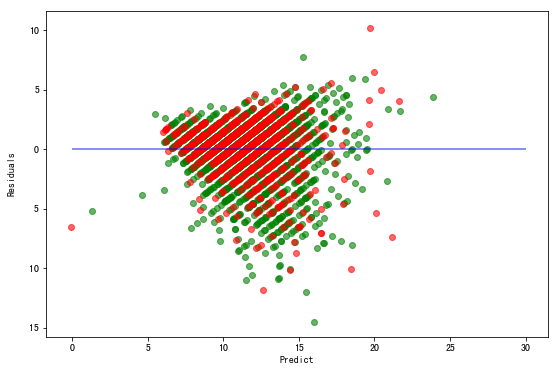

In [22]:
plt.figure(figsize=(9, 6))
y_train_pred_ridge = ridge.predict(X_train[features_without_ones])
plt.scatter(y_train_pred_ridge, y_train_pred_ridge - y_train, c="g", alpha=0.6)
plt.scatter(y_test_pred_ridge, y_test_pred_ridge - y_test, c="r",alpha=0.6)
plt.hlines(y=0, xmin=0, xmax=30,color="b",alpha=0.6)
plt.ylabel("Residuals")
plt.xlabel("Predict")

### 5.3 岭迹

In [23]:
alphas = np.logspace(-10,10,20)
coef = pd.DataFrame()
for alpha in alphas:
    ridge_clf = Ridge(alpha=alpha)
    ridge_clf.fit(X_train[features_without_ones],y_train)
    df = pd.DataFrame([ridge_clf.coef_],columns=X_train[features_without_ones].columns)
    df['alpha'] = alpha
    coef = coef.append(df,ignore_index=True)
coef.head().round(decimals=2)

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_F,sex_M,alpha
0,-1.12,10.0,20.74,9.61,-20.05,-12.07,6.55,0.88,0.87,0.0
1,-1.12,10.0,20.74,9.61,-20.05,-12.07,6.55,0.88,0.87,0.0
2,-1.12,10.0,20.74,9.61,-20.05,-12.07,6.55,0.88,0.87,0.0
3,-1.12,10.0,20.74,9.61,-20.05,-12.07,6.55,0.88,0.87,0.0
4,-1.12,10.0,20.74,9.61,-20.05,-12.07,6.55,0.88,0.87,0.0


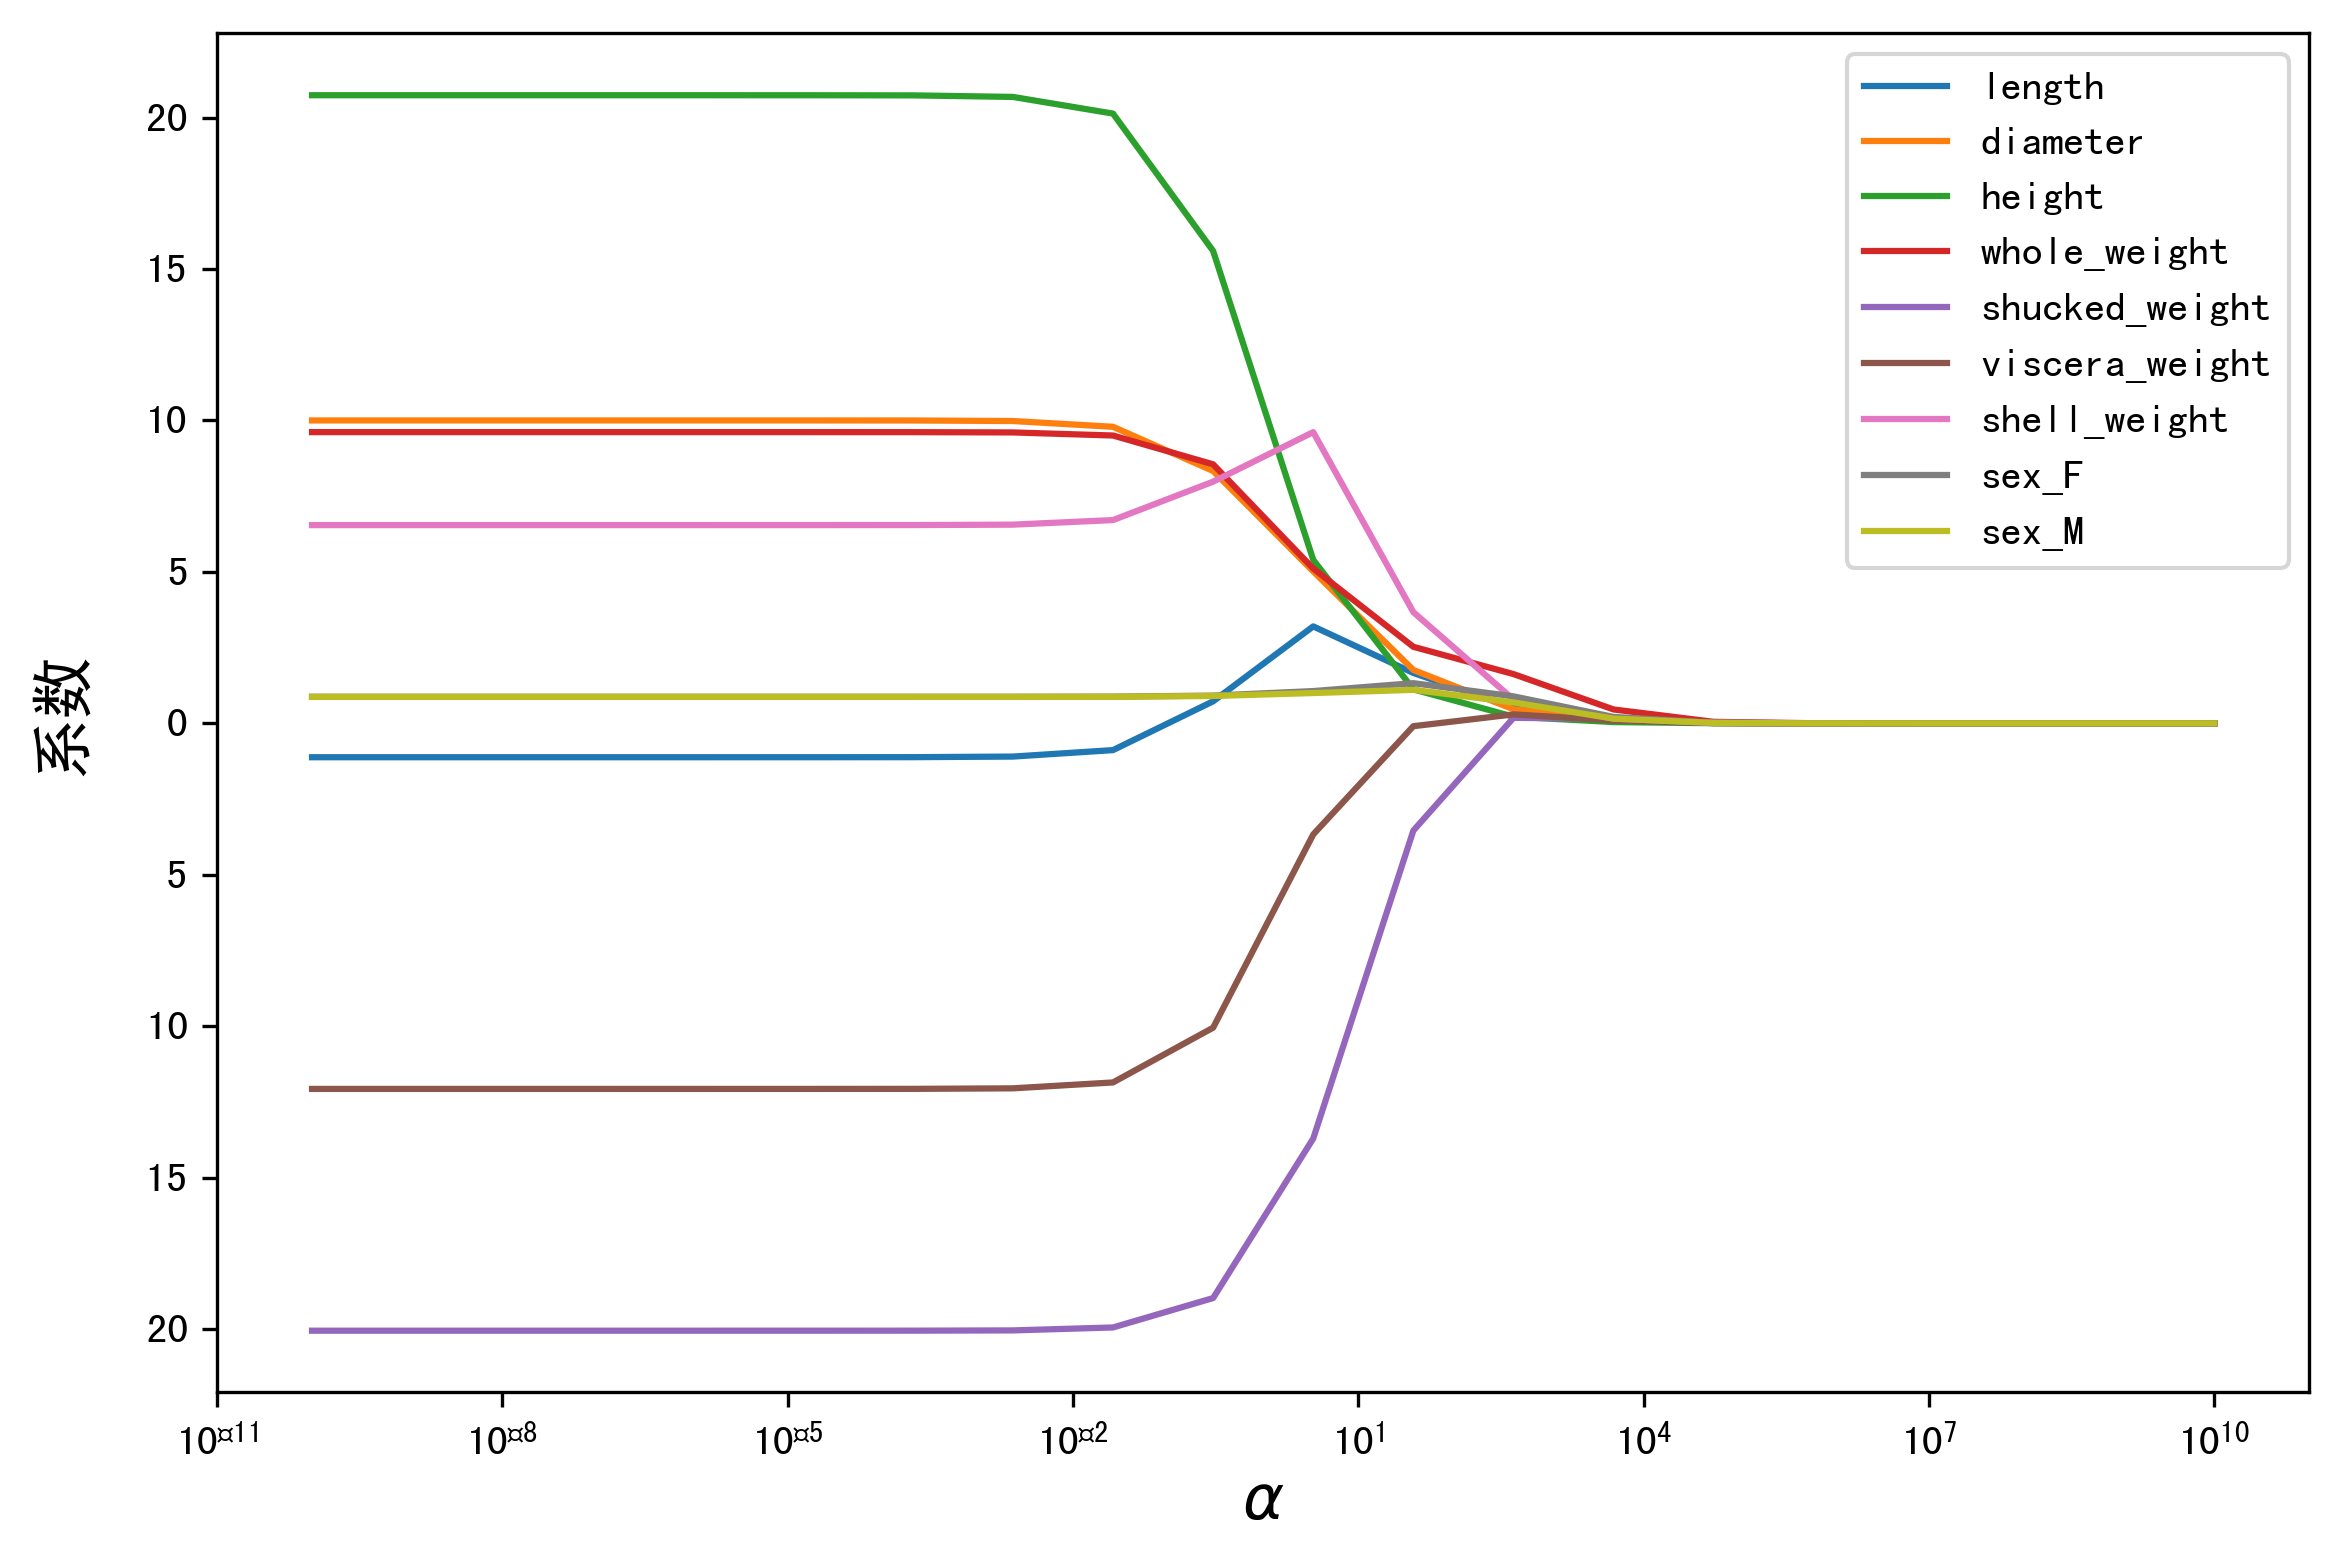

In [24]:
#绘图
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.figure(figsize=(9, 6))
coef['alpha'] = coef['alpha']

for feature in X_train.columns[:-1]:
    plt.plot('alpha',feature,data=coef)
ax = plt.gca()
ax.set_xscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\alpha$',fontsize=15)
plt.ylabel('系数',fontsize=15)

plt.show()

### 5.4 LASSO 的正则化路径


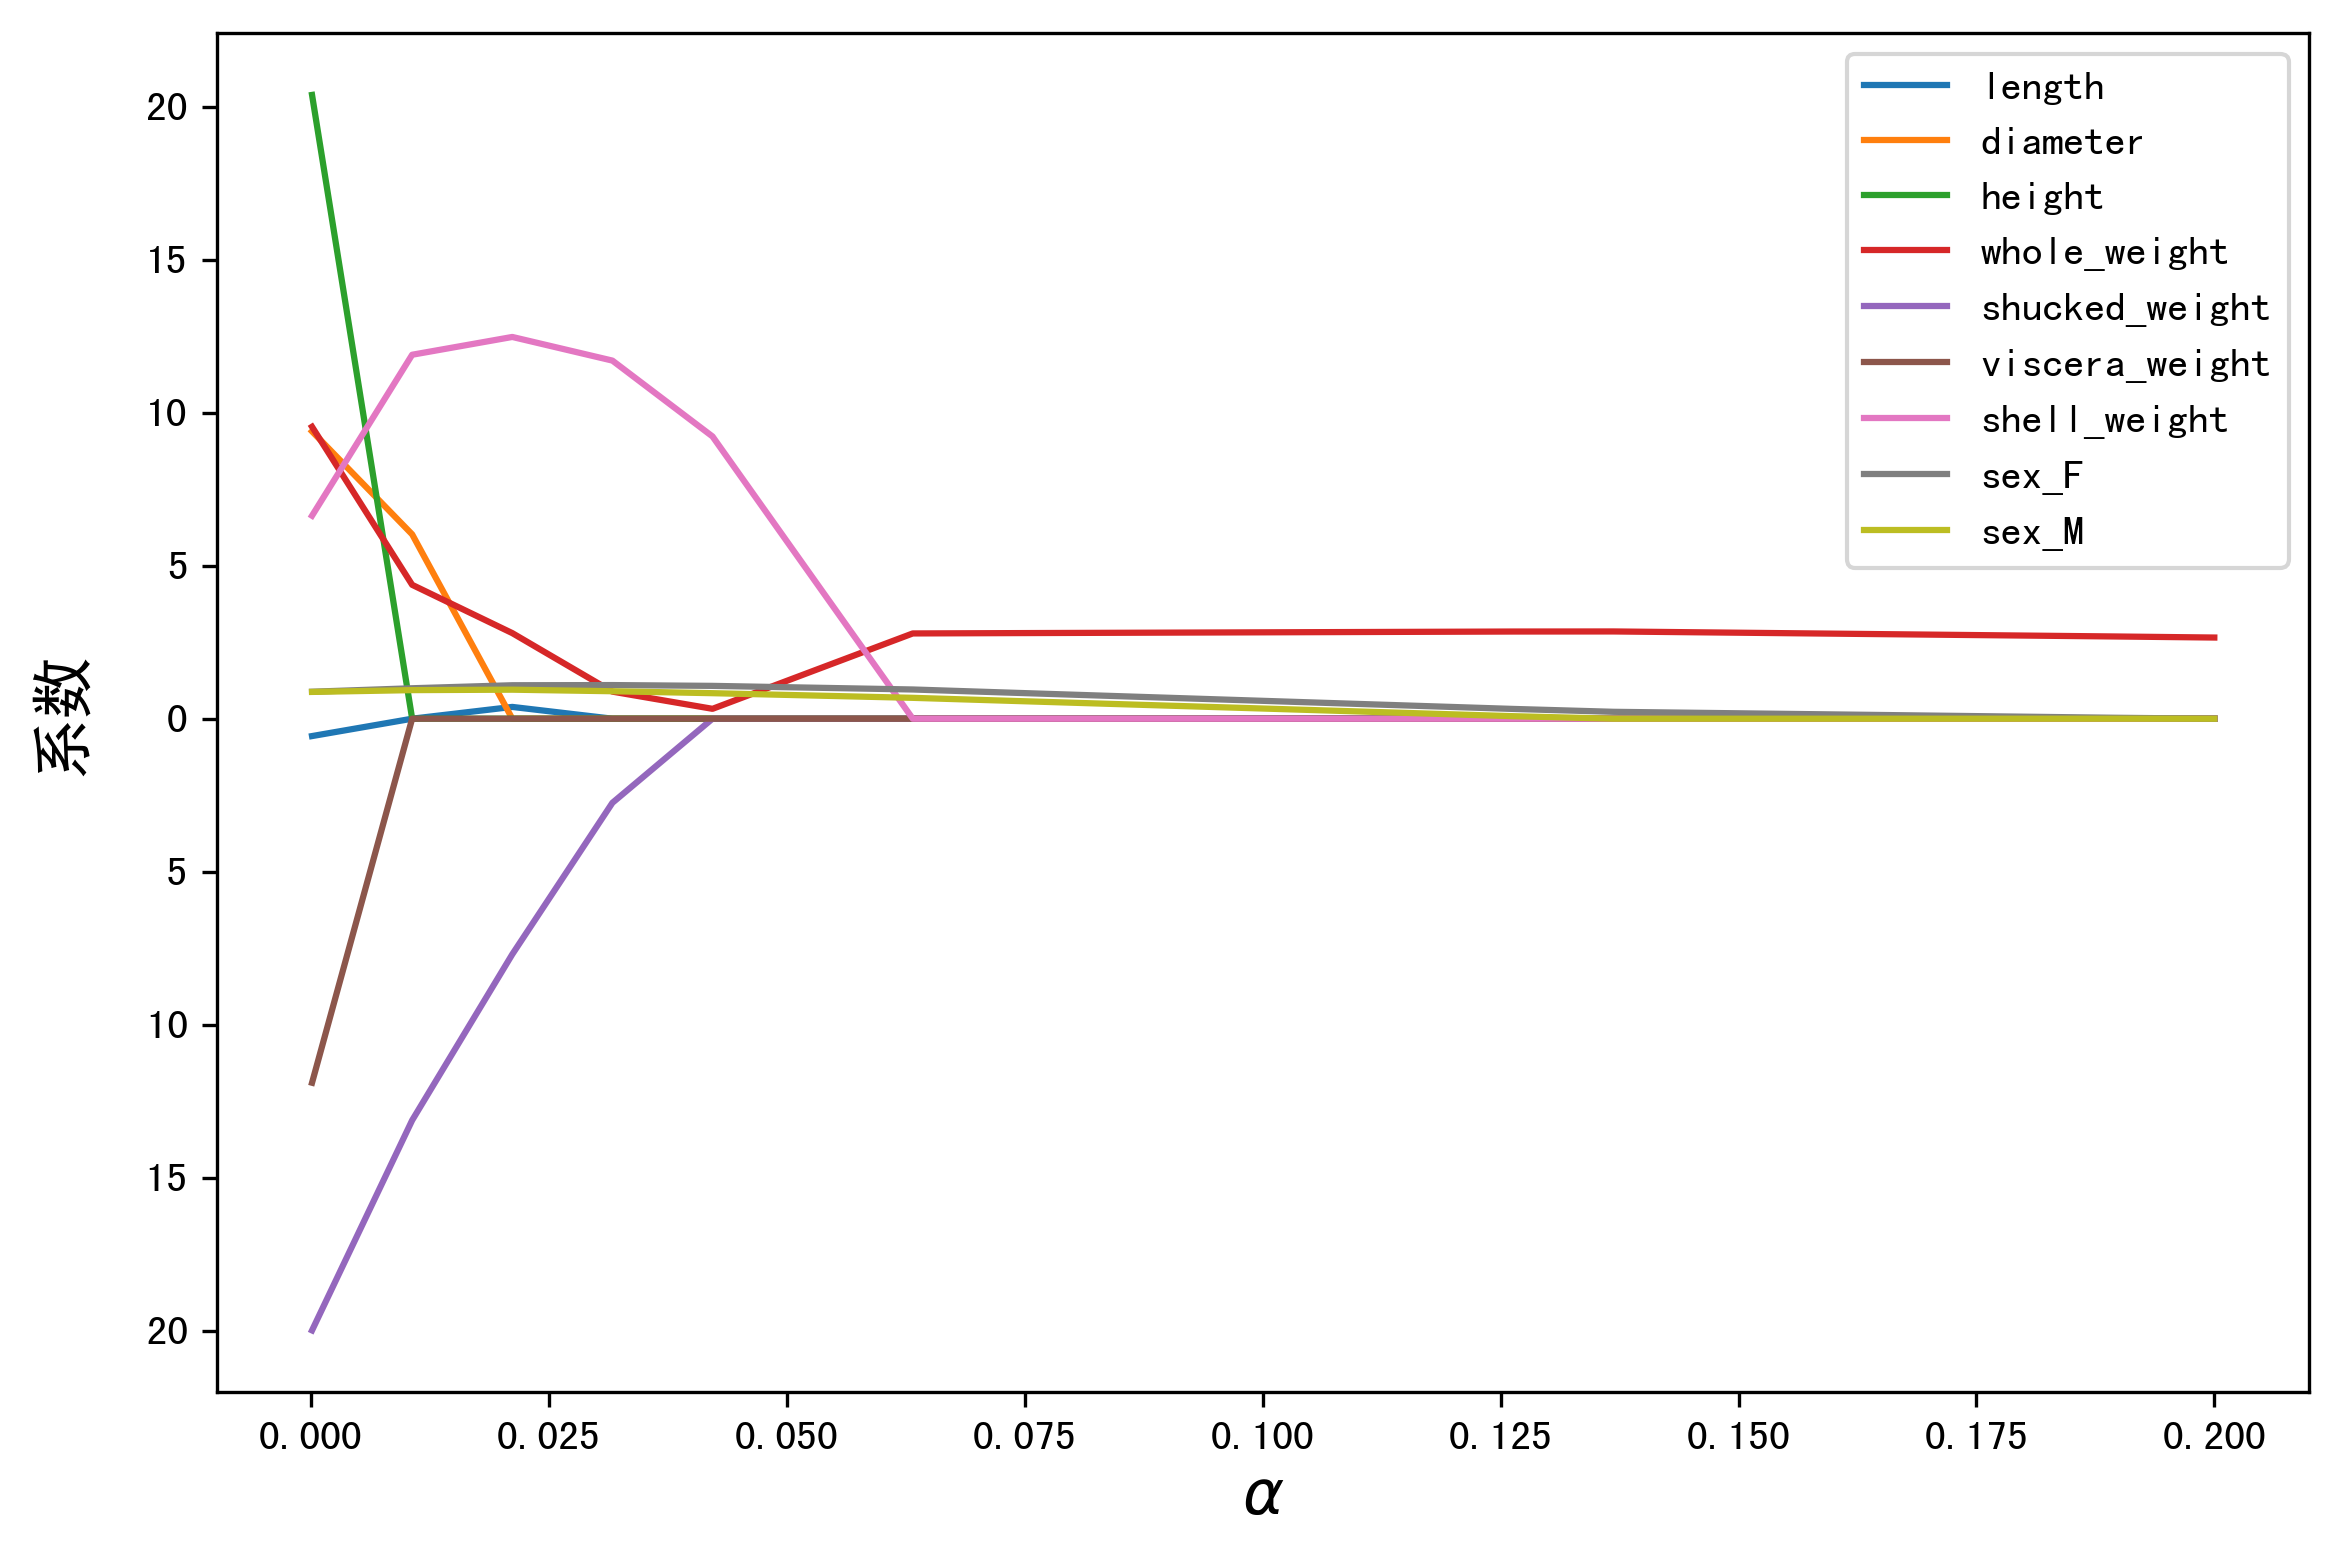

In [25]:
coef = pd.DataFrame()
for alpha in np.linspace(0.0001,0.2,20):
    lasso_clf = Lasso(alpha=alpha)
    lasso_clf.fit(X_train[features_without_ones],y_train)
    df = pd.DataFrame([lasso_clf.coef_],columns=X_train[features_without_ones].columns)
    df['alpha'] = alpha
    coef = coef.append(df,ignore_index=True)
coef.head()
#绘图
plt.figure(figsize=(9, 6))
for feature in X_train.columns[:-1]:
    plt.plot('alpha',feature,data=coef)
plt.legend(loc='upper right')
plt.xlabel(r'$\alpha$',fontsize=15)
plt.ylabel('系数',fontsize=15)
plt.show()

## 6 总结
在本案例中，我们使用 `Numpy` 分别实现了线性回归和岭回归，并与 `Sklearn` 的实现进行了对比。在一个鲍鱼数据集上，分别使用线性回归和正则化的线性回归构建了鲍鱼年龄预测模型。